# 过拟合、欠拟合及其解决方案
1. 过拟合、欠拟合的概念
2. 权重衰减
3. 丢弃法

# 模型选择、过拟合和欠拟合

## 训练误差和泛化误差
在解释上述现象之前，我们需要区分训练误差（training error）和泛化误差（generalization error）。通俗来讲，前者指模型在训练数据集上表现出的误差，后者指模型在任意一个测试数据样本上表现出的误差的期望，并常常通过测试数据集上的误差来近似。计算训练误差和泛化误差可以使用之前介绍过的损失函数，例如线性回归用到的平方损失函数和softmax回归用到的交叉熵损失函数。

机器学习模型应关注降低泛化误差。

## 模型选择
### 验证数据集
从严格意义上讲，测试集只能在所有超参数和模型参数选定后使用一次。不可以使用测试数据选择模型，如调参。由于无法从训练误差估计泛化误差，因此也不应只依赖训练数据选择模型。鉴于此，我们可以预留一部分在训练数据集和测试数据集以外的数据来进行模型选择。这部分数据被称为验证数据集，简称验证集（validation set）。例如，我们可以从给定的训练集中随机选取一小部分作为验证集，而将剩余部分作为真正的训练集。

### K折交叉验证  
由于验证数据集不参与模型训练，当训练数据不够用时，预留大量的验证数据显得太奢侈。一种改善的方法是K折交叉验证（K-fold cross-validation）。在K折交叉验证中，我们把原始训练数据集分割成K个不重合的子数据集，然后我们做K次模型训练和验证。每一次，我们使用一个子数据集验证模型，并使用其他K-1个子数据集来训练模型。在这K次训练和验证中，每次用来验证模型的子数据集都不同。最后，我们对这K次训练误差和验证误差分别求平均。
## 过拟合和欠拟合
接下来，我们将探究模型训练中经常出现的两类典型问题：
- 一类是模型无法得到较低的训练误差，我们将这一现象称作欠拟合（underfitting）；
- 另一类是模型的训练误差远小于它在测试数据集上的误差，我们称该现象为过拟合（overfitting）。
在实践中，我们要尽可能同时应对欠拟合和过拟合。虽然有很多因素可能导致这两种拟合问题，在这里我们重点讨论两个因素：模型复杂度和训练数据集大小。

### 模型复杂度
为了解释模型复杂度，我们以多项式函数拟合为例。给定一个由标量数据特征$x$和对应的标量标签$y$组成的训练数据集，多项式函数拟合的目标是找一个$K$阶多项式函数


$$
 \hat{y} = b + \sum_{k=1}^K x^k w_k 
$$


来近似 $y$。在上式中，$w_k$是模型的权重参数，$b$是偏差参数。与线性回归相同，多项式函数拟合也使用平方损失函数。特别地，一阶多项式函数拟合又叫线性函数拟合。

给定训练数据集，模型复杂度和误差之间的关系：

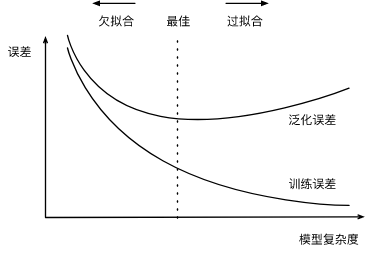

### 训练数据集大小
影响欠拟合和过拟合的另一个重要因素是训练数据集的大小。一般来说，如果训练数据集中样本数过少，特别是比模型参数数量（按元素计）更少时，过拟合更容易发生。此外，泛化误差不会随训练数据集里样本数量增加而增大。因此，在计算资源允许的范围之内，我们通常希望训练数据集大一些，特别是在模型复杂度较高时，例如层数较多的深度学习模型。


# 多项式函数拟合实验

In [3]:
%matplotlib inline
import torch
import numpy as np
import sys
sys.path.append("/home/kesci/input")
import d2lzh1981 as d2l
print(torch.__version__)

1.3.0


## 初始化模型参数

In [4]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = torch.randn((n_train + n_test, 1))
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), 1) 
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
          + true_w[2] * poly_features[:, 2] + true_b)
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

In [5]:
features[:2], poly_features[:2], labels[:2]

(tensor([[-0.8589],
         [-0.2534]]), tensor([[-0.8589,  0.7377, -0.6335],
         [-0.2534,  0.0642, -0.0163]]), tensor([-2.0794,  4.4039]))

## 定义、训练和测试模型

In [6]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    # d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)

In [7]:
num_epochs, loss = 100, torch.nn.MSELoss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    # 初始化网络模型
    net = torch.nn.Linear(train_features.shape[-1], 1)
    # 通过Linear文档可知，pytorch已经将参数初始化了，所以我们这里就不手动初始化了
    
    # 设置批量大小
    batch_size = min(10, train_labels.shape[0])    
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)      # 设置数据集
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True) # 设置获取数据方式
    
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)                      # 设置优化函数，使用的是随机梯度下降优化
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:                                                 # 取一个批量的数据
            l = loss(net(X), y.view(-1, 1))                                     # 输入到网络中计算输出，并和标签比较求得损失函数
            optimizer.zero_grad()                                               # 梯度清零，防止梯度累加干扰优化
            l.backward()                                                        # 求梯度
            optimizer.step()                                                    # 迭代优化函数，进行参数优化
        train_labels = train_labels.view(-1, 1)
        test_labels = test_labels.view(-1, 1)
        train_ls.append(loss(net(train_features), train_labels).item())         # 将训练损失保存到train_ls中
        test_ls.append(loss(net(test_features), test_labels).item())            # 将测试损失保存到test_ls中
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])    
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net.weight.data,
          '\nbias:', net.bias.data)

## 三阶多项式函数拟合（正常）

In [8]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:])

final epoch: train loss 8887.298828125 test loss 1145.94287109375
weight: tensor([[-8.5120, 19.0351, 12.8616]]) 
bias: tensor([-5.4607])


<Figure size 432x288 with 1 Axes>

## 线性函数拟合（欠拟合）

In [9]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train], labels[n_train:])

final epoch: train loss 781.689453125 test loss 329.79852294921875
weight: tensor([[26.8753]]) 
bias: tensor([6.1426])


<Figure size 432x288 with 1 Axes>

## 训练样本不足（过拟合）

In [10]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2], labels[n_train:])

final epoch: train loss 6.23520565032959 test loss 409.9844665527344
weight: tensor([[ 0.9729, -0.9612,  0.7259]]) 
bias: tensor([1.6334])


<Figure size 432x288 with 1 Axes>

# 权重衰减
## 方法  
权重衰减等价于 $L_2$ 范数正则化（regularization）。正则化通过为模型损失函数添加惩罚项使学出的模型参数值较小，是应对过拟合的常用手段。

##  L2 范数正则化（regularization）
$L_2$范数正则化在模型原损失函数基础上添加$L_2$范数惩罚项，从而得到训练所需要最小化的函数。$L_2$范数惩罚项指的是模型权重参数每个元素的平方和与一个正的常数的乘积。以线性回归中的线性回归损失函数为例


$$
 \ell(w_1, w_2, b) = \frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(x_1^{(i)} w_1 + x_2^{(i)} w_2 + b - y^{(i)}\right)^2 
$$


其中$w_1, w_2$是权重参数，$b$是偏差参数，样本$i$的输入为$x_1^{(i)}, x_2^{(i)}$，标签为$y^{(i)}$，样本数为$n$。将权重参数用向量$\boldsymbol{w} = [w_1, w_2]$表示，带有$L_2$范数惩罚项的新损失函数为


$$
\ell(w_1, w_2, b) + \frac{\lambda}{2n} |\boldsymbol{w}|^2,
$$


其中超参数$\lambda > 0$。当权重参数均为0时，惩罚项最小。当$\lambda$较大时，惩罚项在损失函数中的比重较大，这通常会使学到的权重参数的元素较接近0。当$\lambda$设为0时，惩罚项完全不起作用。上式中$L_2$范数平方$|\boldsymbol{w}|^2$展开后得到$w_1^2 + w_2^2$。
有了$L_2$范数惩罚项后，在小批量随机梯度下降中，我们将线性回归一节中权重$w_1$和$w_2$的迭代方式更改为


$$
 \begin{aligned} w_1 &\leftarrow \left(1- \frac{\eta\lambda}{|\mathcal{B}|} \right)w_1 - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}}x_1^{(i)} \left(x_1^{(i)} w_1 + x_2^{(i)} w_2 + b - y^{(i)}\right),\\ w_2 &\leftarrow \left(1- \frac{\eta\lambda}{|\mathcal{B}|} \right)w_2 - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}}x_2^{(i)} \left(x_1^{(i)} w_1 + x_2^{(i)} w_2 + b - y^{(i)}\right). \end{aligned} 
$$


可见，$L_2$范数正则化令权重$w_1$和$w_2$先自乘小于1的数，再减去不含惩罚项的梯度。因此，$L_2$范数正则化又叫权重衰减。权重衰减通过惩罚绝对值较大的模型参数为需要学习的模型增加了限制，这可能对过拟合有效。


## 高维线性回归实验从零开始的实现
下面，我们以高维线性回归为例来引入一个过拟合问题，并使用权重衰减来应对过拟合。设数据样本特征的维度为$p$。对于训练数据集和测试数据集中特征为$x_1, x_2, \ldots, x_p$的任一样本，我们使用如下的线性函数来生成该样本的标签：


$$
 y = 0.05 + \sum_{i = 1}^p 0.01x_i + \epsilon 
$$


其中噪声项$\epsilon$服从均值为0、标准差为0.01的正态分布。为了较容易地观察过拟合，我们考虑高维线性回归问题，如设维度$p=200$；同时，我们特意把训练数据集的样本数设低，如20。

In [11]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import sys
sys.path.append("/home/kesci/input")
import d2lzh1981 as d2l

print(torch.__version__)

1.3.0


## 初始化模型参数
与前面观察过拟合和欠拟合现象的时候相似，在这里不再解释。

In [12]:
n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = torch.ones(num_inputs, 1) * 0.01, 0.05

features = torch.randn((n_train + n_test, num_inputs))
labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

In [13]:
# 定义参数初始化函数，初始化模型参数并且附上梯度
def init_params():
    w = torch.randn((num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

## 定义L2范数惩罚项

In [14]:
def l2_penalty(w):
    return (w**2).sum() / 2

## 定义训练和测试

In [15]:
batch_size, num_epochs, lr = 1, 100, 0.003
net, loss = d2l.linreg, d2l.squared_loss

dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            # 添加了L2范数惩罚项
            l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l = l.sum()
            
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            d2l.sgd([w, b], lr, batch_size)
        train_ls.append(loss(net(train_features, w, b), train_labels).mean().item())
        test_ls.append(loss(net(test_features, w, b), test_labels).mean().item())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', w.norm().item())

## 观察过拟合

In [16]:
fit_and_plot(lambd=0)

L2 norm of w: 11.6444091796875


<Figure size 252x180 with 1 Axes>

## 使用权重衰减

In [17]:
fit_and_plot(lambd=3)

L2 norm of w: 0.04063604772090912


<Figure size 252x180 with 1 Axes>

## 简洁实现

In [18]:
def fit_and_plot_pytorch(wd):
    # 对权重参数衰减。权重名称一般是以weight结尾
    net = nn.Linear(num_inputs, 1)
    nn.init.normal_(net.weight, mean=0, std=1)
    nn.init.normal_(net.bias, mean=0, std=1)
    optimizer_w = torch.optim.SGD(params=[net.weight], lr=lr, weight_decay=wd) # 对权重参数衰减
    optimizer_b = torch.optim.SGD(params=[net.bias], lr=lr)  # 不对偏差参数衰减
    
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            
            l.backward()
            
            # 对两个optimizer实例分别调用step函数，从而分别更新权重和偏差
            optimizer_w.step()
            optimizer_b.step()
        train_ls.append(loss(net(train_features), train_labels).mean().item())
        test_ls.append(loss(net(test_features), test_labels).mean().item())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net.weight.data.norm().item())

In [19]:
fit_and_plot_pytorch(0)

L2 norm of w: 13.361410140991211


<Figure size 252x180 with 1 Axes>

In [20]:
fit_and_plot_pytorch(3)

L2 norm of w: 0.051789578050374985


<Figure size 252x180 with 1 Axes>

# 丢弃法

多层感知机中神经网络图描述了一个单隐藏层的多层感知机。其中输入个数为4，隐藏单元个数为5，且隐藏单元$h_i$（$i=1, \ldots, 5$）的计算表达式为


$$
 h_i = \phi\left(x_1 w_{1i} + x_2 w_{2i} + x_3 w_{3i} + x_4 w_{4i} + b_i\right) 
$$


这里$\phi$是激活函数，$x_1, \ldots, x_4$是输入，隐藏单元$i$的权重参数为$w_{1i}, \ldots, w_{4i}$，偏差参数为$b_i$。当对该隐藏层使用丢弃法时，该层的隐藏单元将有一定概率被丢弃掉。设丢弃概率为$p$，那么有$p$的概率$h_i$会被清零，有$1-p$的概率$h_i$会除以$1-p$做拉伸。丢弃概率是丢弃法的超参数。具体来说，设随机变量$\xi_i$为0和1的概率分别为$p$和$1-p$。使用丢弃法时我们计算新的隐藏单元$h_i'$


$$
 h_i' = \frac{\xi_i}{1-p} h_i 
$$


由于$E(\xi_i) = 1-p$，因此


$$
 E(h_i') = \frac{E(\xi_i)}{1-p}h_i = h_i 
$$


即丢弃法不改变其输入的期望值。让我们对之前多层感知机的神经网络中的隐藏层使用丢弃法，一种可能的结果如图所示，其中$h_2$和$h_5$被清零。这时输出值的计算不再依赖$h_2$和$h_5$，在反向传播时，与这两个隐藏单元相关的权重的梯度均为0。由于在训练中隐藏层神经元的丢弃是随机的，即$h_1, \ldots, h_5$都有可能被清零，输出层的计算无法过度依赖$h_1, \ldots, h_5$中的任一个，从而在训练模型时起到正则化的作用，并可以用来应对过拟合。在测试模型时，我们为了拿到更加确定性的结果，一般不使用丢弃法

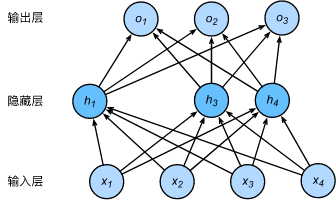



## 丢弃法从零开始的实现

In [21]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import sys
sys.path.append("/home/kesci/input")
import d2lzh1981 as d2l

print(torch.__version__)

1.3.0


In [22]:
def dropout(X, drop_prob):
    X = X.float()
    assert 0 <= drop_prob <= 1
    keep_prob = 1 - drop_prob
    # 这种情况下把全部元素都丢弃
    if keep_prob == 0:
        return torch.zeros_like(X)
    mask = (torch.rand(X.shape) < keep_prob).float()
    
    return mask * X / keep_prob

In [23]:
X = torch.arange(16).view(2, 8)
dropout(X, 0)

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])

In [24]:
dropout(X, 0.5)

tensor([[ 0.,  0.,  0.,  6.,  8., 10.,  0., 14.],
        [ 0.,  0., 20.,  0.,  0.,  0., 28.,  0.]])

In [25]:
dropout(X, 1.0)

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [26]:
# 参数的初始化
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

W1 = torch.tensor(np.random.normal(0, 0.01, size=(num_inputs, num_hiddens1)), dtype=torch.float, requires_grad=True)
b1 = torch.zeros(num_hiddens1, requires_grad=True)
W2 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens1, num_hiddens2)), dtype=torch.float, requires_grad=True)
b2 = torch.zeros(num_hiddens2, requires_grad=True)
W3 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens2, num_outputs)), dtype=torch.float, requires_grad=True)
b3 = torch.zeros(num_outputs, requires_grad=True)

params = [W1, b1, W2, b2, W3, b3]

In [27]:
drop_prob1, drop_prob2 = 0.2, 0.5

def net(X, is_training=True):
    X = X.view(-1, num_inputs)
    H1 = (torch.matmul(X, W1) + b1).relu()
    if is_training:  # 只在训练模型时使用丢弃法
        H1 = dropout(H1, drop_prob1)  # 在第一层全连接后添加丢弃层
    H2 = (torch.matmul(H1, W2) + b2).relu()
    if is_training:
        H2 = dropout(H2, drop_prob2)  # 在第二层全连接后添加丢弃层
    return torch.matmul(H2, W3) + b3

In [28]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        if isinstance(net, torch.nn.Module):
            net.eval() # 评估模式, 这会关闭dropout
            acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
            net.train() # 改回训练模式
        else: # 自定义的模型
            if('is_training' in net.__code__.co_varnames): # 如果有is_training这个参数
                # 将is_training设置成False
                acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
            else:
                acc_sum += (net(X).argmax(dim=1) == y).float().sum().item() 
        n += y.shape[0]
    return acc_sum / n

In [29]:
num_epochs, lr, batch_size = 5, 100.0, 256  # 这里的学习率设置的很大，原因与之前相同。
loss = torch.nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, root='/home/kesci/input/FashionMNIST2065')
d2l.train_ch3(
    net,
    train_iter,
    test_iter,
    loss,
    num_epochs,
    batch_size,
    params,
    lr)


epoch 1, loss 0.0046, train acc 0.549, test acc 0.704
epoch 2, loss 0.0023, train acc 0.785, test acc 0.737
epoch 3, loss 0.0019, train acc 0.825, test acc 0.834
epoch 4, loss 0.0017, train acc 0.842, test acc 0.763
epoch 5, loss 0.0016, train acc 0.848, test acc 0.813


## 简洁实现

In [30]:
net = nn.Sequential(
        d2l.FlattenLayer(),
        nn.Linear(num_inputs, num_hiddens1),
        nn.ReLU(),
        nn.Dropout(drop_prob1),
        nn.Linear(num_hiddens1, num_hiddens2), 
        nn.ReLU(),
        nn.Dropout(drop_prob2),
        nn.Linear(num_hiddens2, 10)
        )

for param in net.parameters():
    nn.init.normal_(param, mean=0, std=0.01)

In [31]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0046, train acc 0.553, test acc 0.736
epoch 2, loss 0.0023, train acc 0.785, test acc 0.803
epoch 3, loss 0.0019, train acc 0.818, test acc 0.756
epoch 4, loss 0.0018, train acc 0.835, test acc 0.829
epoch 5, loss 0.0016, train acc 0.848, test acc 0.851


# 总结

- 欠拟合现象：模型无法达到一个较低的误差
    
- 过拟合现象：训练误差较低但是泛化误差依然较高，二者相差较大
